# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.weightstats import ztest

df = pd.read_csv('data/human_body_temperature.csv')

# 1. Tests for Normality

First, the function that will be used to conduct a graphical test for normality is defined. This is the ecdf function, which takes an array of data as an argument and returns a series of values corresponding to the array's cumulative distribution function as paired x, y arrays.

In [10]:
def ecdf(d):
    """Computes the CDF of the data passed as an argument"""
    # Number of data points: n
    n = len(d)
    
    # The x values are the values observed in the data, sorted from smallest to largest
    x = np.sort(d)

    # The y values are the proportion of values that are equal to or greater than x, which is the same as a list of values
    # equal to 1/n for the 1st smallest x valu, 2/n for the 2nd smallest x value, etc.
    y = np.arange(1, n+1) / n

    return x, y

Next, an ECDF is created from the observed temperature data, which is used to graph the temperature data against the CDF of a normal distribution. The CDFs of the two graphs appear to be roughly the same, so human body temperature appears to be normally distributed.

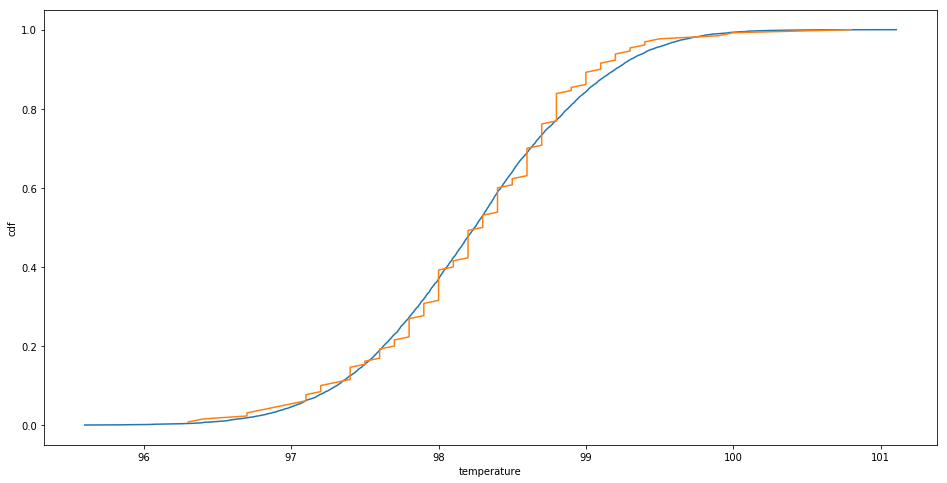

In [31]:
# Create the x, y values for the CDF of the observed temperature data
temp = df['temperature']
x, y = ecdf(temp)

# Compute the mean and standard deviation of the temperature sample data
mean_temp = temp.mean()
std_temp = temp.std()

# Simulate a normal distribution with the mean and standard deviation of the sample data using np.random
normal_sim = np.random.normal(mean_temp, std_temp, 10000)

# Create the x, y values for the CDF of the simulated data
x_sim, y_sim = ecdf(normal_sim)

# Set the figure size to be large enough to evaluate
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the simulated normal distribution
_ = plt.plot(x_sim, y_sim)

# Plot the sample CDF
_ = plt.plot(x, y)

# Label the axes and show the graph
_ = plt.xlabel('temperature (degrees F)')
_ = plt.ylabel('cdf')
plt.show()

To ensure that the graphical analysis above is accurate, the Shapiro-Wilk test for normality is performed on the temperature data with a significance level of .05. The result is a p-value of ~.23, which indicates that the observed temperature sample is not statistically different from that of a normal distribution.

In [41]:
shapiro_mean, shapiro_p = stats.shapiro(temp)
print(shapiro_p)

0.2331680953502655


# 2. Sample Size and Independence

A condition for the Central Limit Theorem (CLT) to apply is that the sample size is sufficiently large, commonly defined as a sample over 30. There are 130 observations in our sample, as shown below, which is sufficient for the CLT.

The dataset is described in the link that follows, in which the authors assert that the sample of 130 is selected from a sample of 700 measurements of body temperature over 2 days from a number of subjects. There is no reason to believe that these samples were taken in a way that would make the values non-independent, so the independence condition appears to hold.
http://jse.amstat.org/v4n2/datasets.shoemaker.html

In [42]:
len(temp)

130

# 3. Comparison of Sample Mean to 98.6 Degrees

## Bootstrap Hypothesis Test

A bootstrap replicate will be used to draw 10,000 random 130-value samples from the original data. The null hypothesis is that average human body temperature is 98.6 degrees; the alternative hypothesis is that average human body temperature is not equal to 98.6 degrees. The means of the generated replicates which will be compared to 98.6 degrees to test the hypotheses.

To accomplish this, first the following functions are created to conduct the bootstrap test.

In [43]:
def draw_replicates(d, func, size=10000):
    """The data, function to be tested, and number of replicates are passed in as function parameters. An array of the specified
    size is returned, with each element equal to the given func applied to a random bootstrap sample of the data."""
    replicates = np.empty(size)
    for i in range(size):
        replicates[i] = func(np.random.choice(d, size=len(d)))
        
    return replicates

Next, ten thousand random replicates are drawn. These roughly show what the data would have looked like if the sample were drawn repeatedly. The CDF of the value of these replicates is drawn below; in no replicate is the temperature greater than 98.5 degrees, suggesting a population mean below 96 degrees.

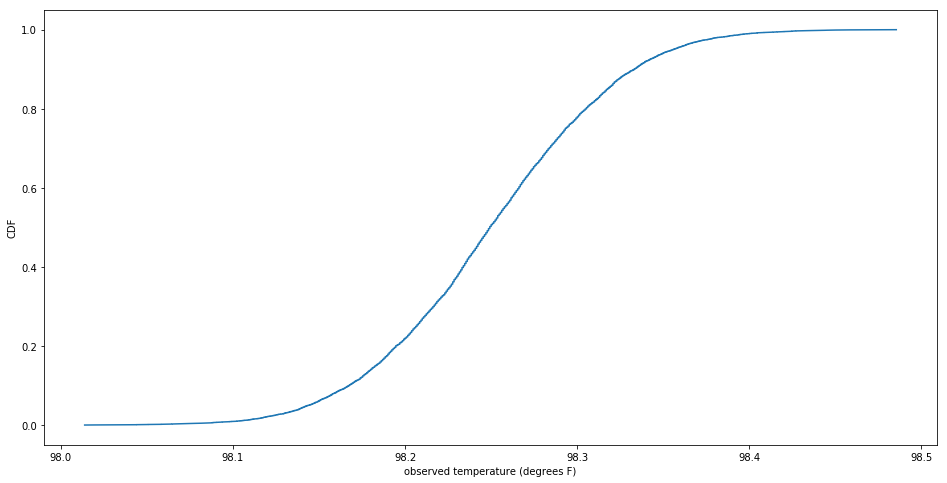

In [49]:
# Draw the bootstrap replicates
bs_temp = draw_replicates(temp, np.mean)

# Create the CDF for the generated bootstrap
x, y = ecdf(bs_temp)

# Set the figure size to be large enough to evaluate
fig, ax = plt.subplots(figsize=(16, 8))

_ = plt.plot(x, y)
_ = plt.xlabel('observed temperature (degrees F)')
_ = plt.ylabel('CDF')
plt.show()

## Frequentist Statistical Tests

A frequentist statistical test is used next to compare the observed population mean to 98.6 degrees. The alternative hypothesis, as mentioned above, is that the true population mean is different from 98.6, not that it is specifically greater than or less than 98.6. A two-tailed test is therefore used.

A t-test is the appropriate statistical test to use. A z-test should be used if the true population standard deviation is known, which it is not. The test below shows a miniscule p value for the representative t-test, demonstrating that it is very unlikely that 98.6 degrees F is the true population mean.

In [50]:
# Use the stats.ttest_1samp function to test the likelihood of getting the observed mean if the true mean is 98.6 degrees F
stats.ttest_1samp(a=temp, popmean=98.6)

Ttest_1sampResult(statistic=-5.4548232923645195, pvalue=2.4106320415561276e-07)

The Z-score is identical, but the P-value that results is lower by approximately a factor of 5. Both P-values are negligibly small and suggest a near-certainty that the true population mean differs from 98.6 degrees F.

In [52]:
ztest(x1=temp, value=98.6)

(-5.4548232923645195, 4.9021570141012155e-08)

# 4. Testing t vs. z Statistics for Small Sample Size

A sample of only 10 values is drawn from the sample of 130 measurements. The p-values from a t-test and a z-test are compared below. As expected, the t-test produces a higher p-value, while the z-test produces a lower p-value. At the p=.05 significance level, the t-test would produce a statistically insignificant result, whereas the z-test would produce a statistically significant result.

The appropriate test to use is a t-test. Not only is the population variance unknown, which makes the t-test a more favorable choice, but the sample size is less than 30, a commonly used cutoff value under which t-tests are to be used.

In [55]:
small_sample = np.random.choice(temp, size=10)
t, t_p = stats.ttest_1samp(a=small_sample, popmean=98.6)
z, z_p = ztest(x1=small_sample, value=98.6)
print('p value from t-test: {}\np value from z-test: {}'.format(t_p, z_p))

p value from t-test: 0.058575714526615155
p value from z-test: 0.030377349902045995


# 5. Normal Temperature Range

An individual's body temperature might be considered outside of the normal range if it is in the 5% most extreme values observed in the sample. This is simply the 2.5th and 97.5th percentiles of the sample, shown below; the "normal" range is 96.72 - 99.48 degrees F.

In [69]:
np.percentile(temp, [2.5, 97.5])

array([96.7225, 99.4775])

## Bootstrap Approach

To test a confidence interval for the observed mean temperature, the formula below takes the already-generated 10,000 bootstrap replicate means and determines the 5% confidence interval for those means. Note that this is different from the individual extreme values calculated above - this is the confidence interval for a n=130 sample mean.

In [68]:
np.percentile(bs_temp, [2.5, 97.5])

array([98.12461538, 98.37615385])

## Frequentist Approach

To calculate the confidence interval using the frequentist approach, the stats.t.interval function is used. Arguments passed to the function are the confidence interval (95%), the number of observations minus one (len(temp) - 1), the mean temperature, and the standard error of the temperature. The results are nearly identical to those from the bootstrap approach.

In [66]:
stats.t.interval(0.95, len(temp)-1, loc=np.mean(temp), scale=stats.sem(temp))

(98.12200290560804, 98.37645863285351)

# 6. Temperature Difference Between Males and Females

The temperature difference between males and females is computed using a two-sample T test. The null hypothesis is that average male and female body temperatures are identical; the alternative hypothesis is that they are different. These will be tested using an alpha=.05 significance level.

First, a temperature array for each gender is created.

In [74]:
female_temp = df.loc[df.gender == 'F']['temperature']
male_temp = df.loc[df.gender == 'M']['temperature']

Next, the two are compared using a two-sample t-test. The p-value of .0239 suggests that there is a statistically significant difference between male and female body temperatures. The negative test statistic when comparing male to female temperatures indicates that male body temperatures are, on average, colder than female body temperatures.

In [75]:
stats.ttest_ind(male_temp, female_temp)

Ttest_indResult(statistic=-2.2854345381656103, pvalue=0.02393188312239561)

As shown below, the average male body temperature is 98.10 degrees F and the average female body temperature in the sample is 98.39 degrees F. This suggests that neither sex has a mean body temperature as high as 98.6 degrees F, demonstrating the likely inaccuracy of the 98.6 degree F approximation.

In [81]:
print('average male body temp: {} degrees F\naverage female body temp: {} degrees F'.format(np.mean(male_temp),
                                                                                            np.mean(female_temp)))

average male body temp: 98.1046153846154 degrees F
average female body temp: 98.39384615384613 degrees F
